# The Data-Generating Process (DGP)

The first part of this notebook introduces the data-generating process.

The second part then introduces the Monte Carlo method to simulate the future price movements of selected stocks.


## Illustrating the DGP

This example illustrates how the assumed model (e.g., the CAPM) attempts to capture the data-generating process (DGP) by introducing systematic components and, hence, altering the return distribution's characteristics.

We assume that returns are normally distributed.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Set seed for reproducibility
np.random.seed(42)

# Simulate data
n = 20000
sigma_eps = 0.15
epsilon = np.random.normal(0, sigma_eps, n)
market_return = np.random.normal(0.1, 0.15, n)  # Market excess return with E[R_m^e] = 10%, std = 15%
Ri_e_pure_noise = epsilon
Ri_e_CAPM_beta1 = market_return + epsilon

#### Baseline (Unconditional DGP with IID Normal Shocks)
Assume an asset’s excess return follows:

$$R_i^e = \varepsilon_i, \quad \varepsilon_i \sim \mathcal{N}(0, \sigma^2)$$

This is a **white noise process** — excess returns are entirely unpredictable, centered at zero, and normally distributed. Here, the DGP is:
- **IID normal** with mean zero,
- No systematic structure (i.e., no risk premium).

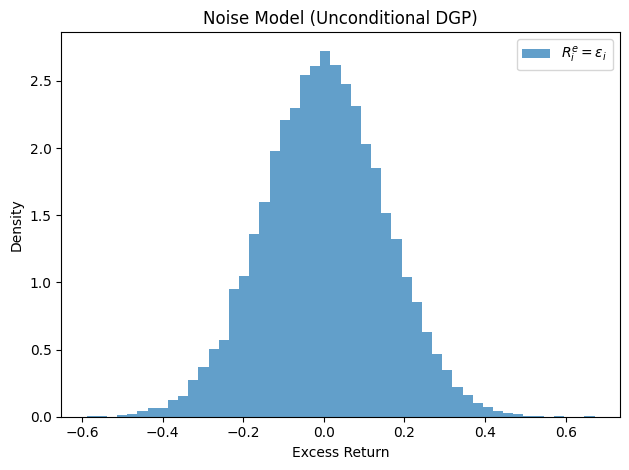

In [13]:
# Plot 1: Pure Noise (iid Normal)
fig1, ax1 = plt.subplots()
ax1.hist(Ri_e_pure_noise, bins=50, density=True, alpha=0.7, label=r'$R_i^e = \varepsilon_i$')
ax1.set_title("Noise Model (Unconditional DGP)")
ax1.set_xlabel("Excess Return")
ax1.set_ylabel("Density")
ax1.legend()

plt.tight_layout()
plt.savefig("noise.png")
plt.show()

#### Conditional DGP under CAPM (with β = 1)

Now assume the asset follows the **CAPM** with beta $\beta_i = 1$:

$$R_i^e = \beta_i R_m^e + \varepsilon_i = R_m^e + \varepsilon_i$$

where:
- $R_m^e$ is the **excess return on the market**,
- $\varepsilon_i \sim \mathcal{N}(0, \sigma^2_{\varepsilon}) $, and $\mathbb{E}[\varepsilon_i \mid R_m^e] = 0$.

Now the DGP is **conditional on the market return** and has:
- **Mean**: $ \mathbb{E}[R_i^e \mid R_m^e] = R_m^e $
- **Variance**: $ \text{Var}(R_i^e \mid R_m^e) = \sigma^2_{\varepsilon} $

So:
- The **mean of the return distribution shifts with the market return**, as you correctly stated.
- The asset’s return is now partly **predictable**, conditional on market movements.
- The asset now **shares systematic risk** and earns a risk premium in expectation:
  $$\mathbb{E}[R_i^e] = \beta_i \mathbb{E}[R_m^e] = \mathbb{E}[R_m^e]$$

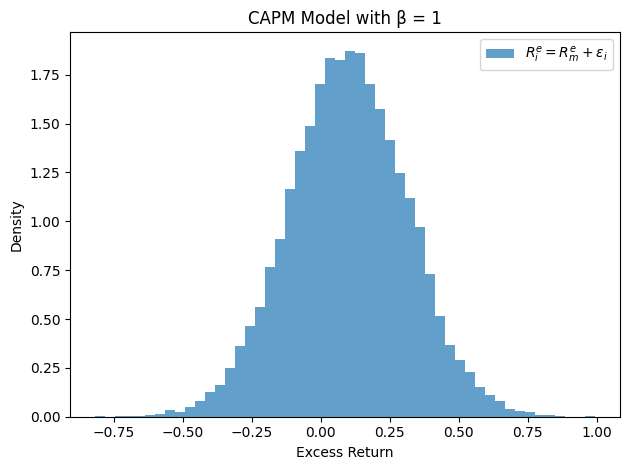

In [14]:
# Plot 2: CAPM with β = 1 (Conditionally Normal)
fig2, ax2 = plt.subplots()
ax2.hist(Ri_e_CAPM_beta1, bins=50, density=True, alpha=0.7, label=r'$R_i^e = R_m^e + \varepsilon_i$')
ax2.set_title("CAPM Model with β = 1")
ax2.set_xlabel("Excess Return")
ax2.set_ylabel("Density")
ax2.legend()

plt.tight_layout()
plt.savefig("beta_noise.png")
plt.show()

#### Implication: Model Choice tries to Capture the DGP
- When using **no model** (just shocks), the DGP is purely stochastic noise.
- Under **CAPM**, the DGP incorporates **structure**: systematic (market-driven) risk + idiosyncratic noise.
- Therefore, **the model tries to capture the underlying structure on the DGP**, transforming the way we understand and forecast returns.

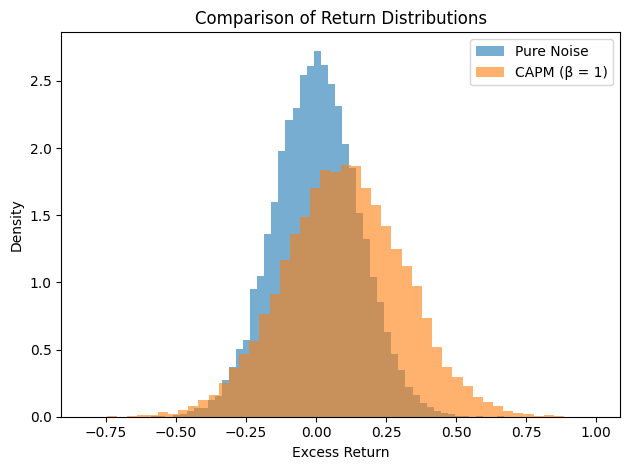

In [15]:
# Plot 3: Compare Distributions
fig3, ax3 = plt.subplots()
ax3.hist(Ri_e_pure_noise, bins=50, density=True, alpha=0.6, label="Pure Noise")
ax3.hist(Ri_e_CAPM_beta1, bins=50, density=True, alpha=0.6, label="CAPM (β = 1)")
ax3.set_title("Comparison of Return Distributions")
ax3.set_xlabel("Excess Return")
ax3.set_ylabel("Density")
ax3.legend()

plt.tight_layout()
plt.savefig("beta_noise_comparison.png")
plt.show()

## Monte-Carlo Analysis of Stock Prices

#### Description:

The Monte Carlo method simulates synthetic return paths based on assumed data-generating processes (DGPs). It draws repeated samples from normal distributions (assumed)--—with constant mean and variance--—to illustrate risk and return characteristics.

#### Preliminary Step #1


*   Install the yfinance Python package
  *   To download market data from Yahoo! Finance API
  *   See: https://pypi.org/project/yfinance/


In [16]:
pip install yfinance


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


#### Preliminary Step #2



*   Import the required packages into Python for our simulations

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

np.random.seed(0)

#### Step 1: Retrieve historical stock data for Apple (AAPL)

We'll retrieve 1008 trading days, which is approximately 4 years.

In [18]:
# Step 1: Retrieve historical stock data for Apple (AAPL)

ticker = 'AAPL'
data = yf.download(ticker, period=str(1008)+'d', interval='1d', auto_adjust=False)

data.to_csv(str(ticker) + '_data.csv')   # save the data as the yfinance api has rate limits

data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,,
2021-03-25,117.966034,120.589996,121.660004,119.000000,119.540001,98844700
2021-03-26,118.572548,121.209999,121.480003,118.919998,120.349998,94071200
2021-03-29,118.748619,121.389999,122.580002,120.730003,121.650002,80819200
2021-03-30,117.291061,119.900002,120.400002,118.860001,120.110001,85671900
2021-03-31,119.492111,122.150002,123.519997,121.150002,121.650002,118323800
...,...,...,...,...,...,...
2025-03-24,220.729996,220.729996,221.479996,218.580002,221.000000,44299500
2025-03-25,223.750000,223.750000,224.100006,220.080002,220.770004,34493600


Step 1.1: Plotting the historical price data

126


/var/folders/kz/18_j95hs0qg31r0hxnhd6_300000gn/T/ipykernel_1202/1499341751.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<module 'matplotlib.pyplot' from '/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/matplotlib/pyplot.py'>

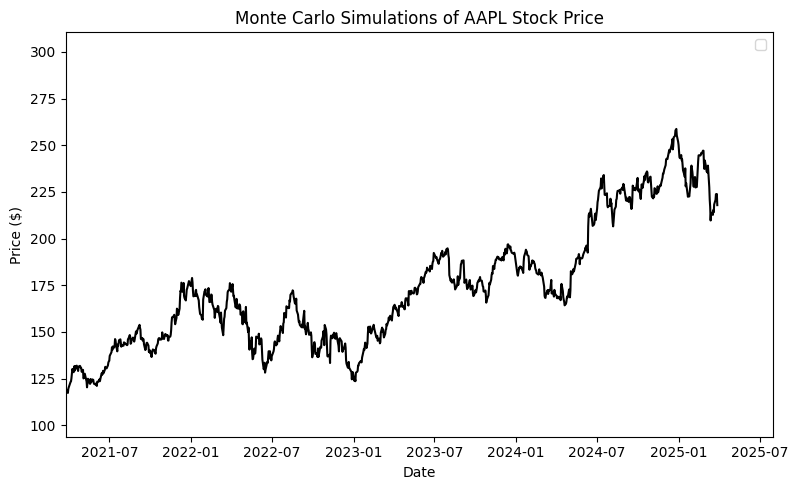

In [19]:
# Plot settings
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Monte Carlo Simulations of AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.tight_layout()

# Historical prices
historical_days = data.index[:]
historical_prices = data['Adj Close'][:]
ax.plot(historical_days, historical_prices, color='black', label='Historical Price')

# Forecast dates
last_day = historical_days[-1]
forecast_dates = pd.date_range(start=last_day, periods=(126 + 1), inclusive='neither')

print(len(forecast_dates))

ax.set_xlim([historical_days[0], forecast_dates[-1]])
ax.set_ylim([(min(historical_prices.values)*0.8), (max(historical_prices.values)*1.2)])

plt

#### Step 2: Define the Parameters for the Monte Carlo simulation



In [20]:
NUM_SIMULATIONS = 200        # Defining the number of Monte Carlo simulations

NUM_DAYS_HISTORY = 1008      # In-sample data ---> fit the distribution

NUM_DAYS_FORECAST = 126      # Out-of-sample ---> forecast

#### Step 3: Calculate the daily returns of the stock


In [21]:
# Step 3: Calculate the daily returns of the stock
daily_returns = np.log(data['Adj Close']/(data['Adj Close'].shift(1))).dropna()

# Calculate the mean and standard deviation of the daily returns
mean_daily_return = daily_returns[len(daily_returns)-NUM_DAYS_HISTORY+1:].mean().item()
std_dev_daily_return = daily_returns[len(daily_returns)-NUM_DAYS_HISTORY+1:].std().item()

Step 3.1: Print the mean return and standard deviation values


In [22]:
print(f"  Mean daily return:      {mean_daily_return:.2%}")
print(f"  Daily std deviation:    {std_dev_daily_return:.2%}\n")

  Mean daily return:      0.06%
  Daily std deviation:    1.65%



Step 3.2: Plot the returns and the return distribution

/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(x))
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/matplotlib/text.py:567: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posx = float(self.convert_xunits(self._x))
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/matplotlib/text.py:905: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(self._x))
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/matplotlib/text.py:762: FutureWarning: Calling float on a single 

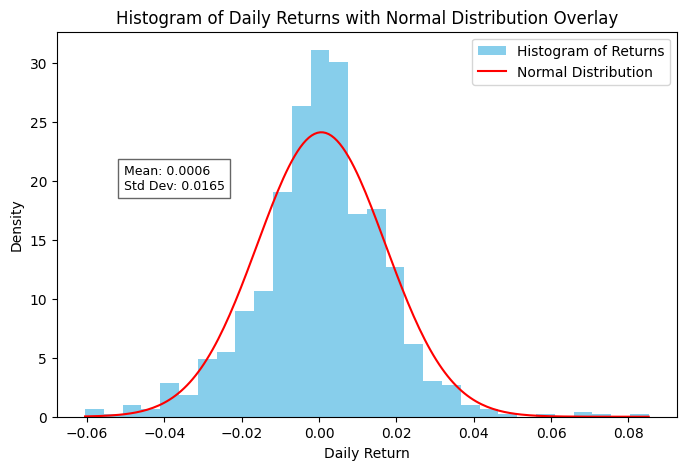

In [23]:
from scipy.stats import norm

# Plot histogram
plt.figure(figsize=(8, 5))
# The key fix: add density=True to make the histogram area sum to 1
plt.hist(daily_returns[len(daily_returns)-NUM_DAYS_HISTORY+1:], bins=30, color='skyblue',
         label='Histogram of Returns', density=True)

# Overlay normal distribution
x = np.linspace(daily_returns[len(daily_returns)-NUM_DAYS_HISTORY+1:].min(),
                daily_returns[len(daily_returns)-NUM_DAYS_HISTORY+1:].max(),
                200)
pdf = norm.pdf(x, loc=mean_daily_return, scale=std_dev_daily_return)
plt.plot(x, pdf, 'r', label='Normal Distribution')

# Add mean and std dev as text
plt.text(x=(daily_returns.min())+0.01,
         y=max(pdf)*0.8,  # Adjusted position to ensure visibility
         s=f"Mean: {mean_daily_return:.4f}\nStd Dev: {std_dev_daily_return:.4f}",
         fontsize=9,
         bbox=dict(facecolor='white', alpha=0.6))

# Add labels and legend
plt.title('Histogram of Daily Returns with Normal Distribution Overlay')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.grid(False)
plt.savefig('normal_returns.pdf')
plt.show()

#### Step 4: Perform Monte Carlo simulation


In [24]:
# Step 4: Perform Monte Carlo simulation

# Initialize an empty array to store the simulation results
monte_carlo_simulations = np.zeros((NUM_SIMULATIONS, NUM_DAYS_FORECAST))

# Generate the simulations
for n in range(NUM_SIMULATIONS):
    monte_carlo_simulations[n, 0] = data['Adj Close'].iloc[-1]
    for i in range(1, NUM_DAYS_FORECAST):
        random_daily_return = np.random.normal(mean_daily_return, std_dev_daily_return)
        monte_carlo_simulations[n, i] = monte_carlo_simulations[n, i-1] * (1 + random_daily_return)

/var/folders/kz/18_j95hs0qg31r0hxnhd6_300000gn/T/ipykernel_1202/3374331670.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  monte_carlo_simulations[n, 0] = data['Adj Close'].iloc[-1]


#### Step 5: Plot the simulation results

/var/folders/kz/18_j95hs0qg31r0hxnhd6_300000gn/T/ipykernel_1202/1003844669.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Expected price at the end of 6 months: $234.49


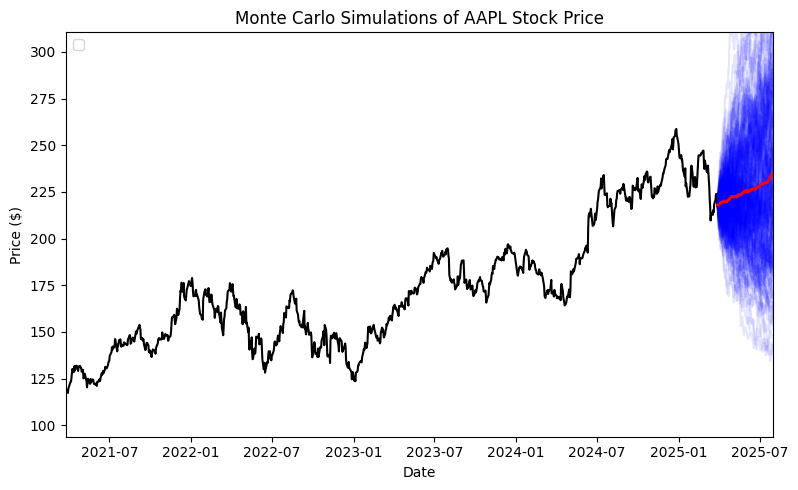

In [25]:
# Step 4: Plot the simulation results
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Monte Carlo Simulations of AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.tight_layout()

# Historical prices
plt.plot(historical_days, historical_prices, color='black', label='Historical Price')

# Plot each simulation path
for n in range(NUM_SIMULATIONS):
    plt.plot(forecast_dates, monte_carlo_simulations[n, :], color='blue', alpha=0.1)

# Plotting the mean of the simulations
mean_simulation = np.mean(monte_carlo_simulations, axis=0)
plt.plot(forecast_dates, mean_simulation, color='red', linewidth=2, label='Mean Simulation')

ax.set_xlim([historical_days[0], forecast_dates[-1]])
ax.set_ylim([(min(historical_prices.values)*0.8), (max(historical_prices.values)*1.2)])

# Optionally, you can calculate the mean expected price at the end of the month
expected_price = np.mean(monte_carlo_simulations[:, -1])
print(f"Expected price at the end of 6 months: ${expected_price:.2f}")

---

#### Testing for Normally Distributed Returns:

skewtest
- Test whether the skew is different from the normal distribution.
- This function tests the null hypothesis that the skewness of the population that the sample was drawn from is the same as that of a corresponding normal distribution.

kurtosistest

- Test whether a dataset has normal kurtosis.
- This function tests the null hypothesis that the kurtosis of the population from which the sample was drawn is that of the normal distribution.

normaltest

- Test whether a sample differs from a normal distribution.
- This function tests the null hypothesis that a sample comes from a normal distribution. It is based on D’Agostino and Pearson’s [1], [2] test that combines skew and kurtosis to produce an omnibus test of normality.

- **Skewness**:
  - $>$ 0: Right-tailed (positive skew)
  - $<$ 0: Left-tailed (negative skew)


- **Excess Kurtosis**:
  - $>$ 0: Leptokurtic (fat tails)
  - $<$ 0: Platykurtic (thin tails)
  - $=$ 0: Mesokurtic (normal distribution)

In [26]:
import scipy.stats as scs

def normality_tests(arr):
    ''' Tests for normality distribution of given data set.

    Parameters
    ==========
    array: ndarray
        object to generate statistics on
    '''
    print('Skew of data set  %14.3f' % scs.skew(arr))
    print('Skew test p-value %14.3f' % scs.skewtest(arr)[1])
    print('Kurt of data set  %14.3f' % scs.kurtosis(arr))
    print('Kurt test p-value %14.3f' % scs.kurtosistest(arr)[1])
    print('Norm test p-value %14.3f' % scs.normaltest(arr)[1])

In [27]:
normality_tests(daily_returns[len(daily_returns)-NUM_DAYS_HISTORY+1:])

Skew of data set          -0.003
Skew test p-value          0.967
Kurt of data set           2.007
Kurt test p-value          0.000
Norm test p-value          0.000


---

#### Volatility Clustering:

Squared returns are a noisy proxy for the true conditional variance.

/var/folders/kz/18_j95hs0qg31r0hxnhd6_300000gn/T/ipykernel_1202/1758517245.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


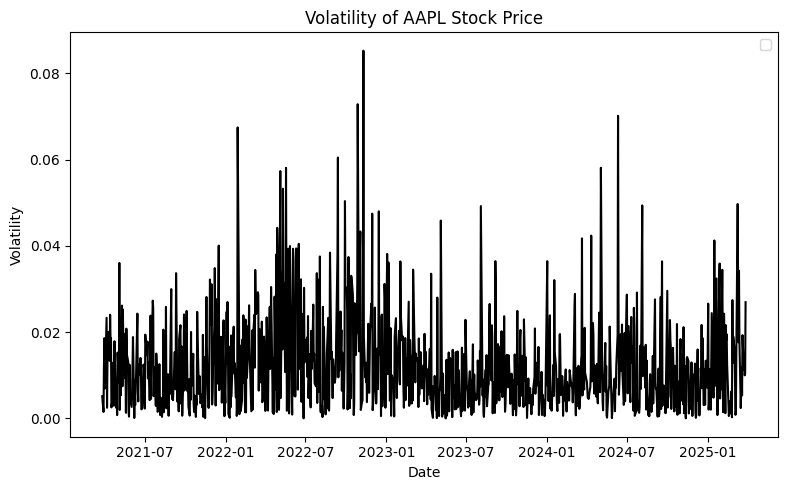

In [29]:
volatility = np.sqrt(daily_returns[len(daily_returns)-NUM_DAYS_HISTORY+1:]**2)

# Step 4: Plot the simulation results
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Volatility of AAPL Stock Price')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()

# Historical prices
plt.plot(historical_days[1:], volatility, color='black', label='Price Volatility')

This is probably better illustrated with the Welch and Goyal (2008) data

In [37]:
xls_path = 'PredictorData2023.xlsx'

goyal = pd.ExcelFile(xls_path)
df = {sheet_name: goyal.parse(sheet_name) for sheet_name in goyal.sheet_names}

# create date index for monthly data
df['Monthly']['yyyymm'] = pd.to_datetime(df['Monthly']['yyyymm'].astype(str), format='%Y%m')
df['Monthly'].set_index('yyyymm', inplace=True)
df['Monthly'].index = df['Monthly'].index.to_period('M').to_timestamp('M')


# create date index for annual data
df['Annual']['yyyy'] = pd.to_datetime(df['Annual']['yyyy'].astype(str), format='%Y')
df['Annual'].set_index('yyyy', inplace=True)
df['Annual'].index = df['Annual'].index.to_period('Y').to_timestamp('Y')

df = df['Monthly']


/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")
/Users/justincase/PycharmProjects/tf_test/.venv/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


/var/folders/kz/18_j95hs0qg31r0hxnhd6_300000gn/T/ipykernel_1202/47702544.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


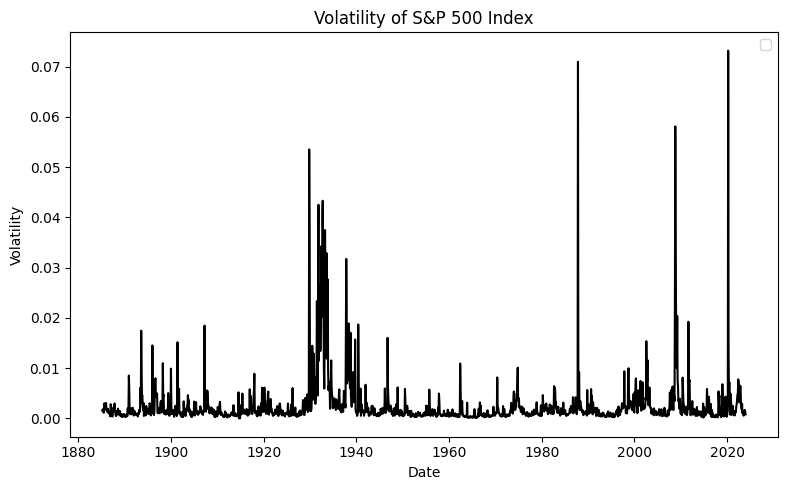

In [38]:
# Step 4: Plot the simulation results
fig, ax = plt.subplots(figsize=(8, 5))
plt.title('Volatility of S&P 500 Index')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.tight_layout()

# Historical prices
plt.plot(df.index, df['svar'], color='black', label='Price Volatility')

---

Notes:

I have used a linear approximation for calculating the price process:

$$S_{t+1} = S_t * (1 + r_t)$$

The more accurate (correct) method would be to consider consider the log-normal distribution implied by geometric Brownian motion.

This can be done with the following code:

In [39]:
Z = np.random.normal(0, 1)
random_log_return = (mean_daily_return - 0.5 * std_dev_daily_return**2) + std_dev_daily_return * Z
monte_carlo_simulations[n, i] = monte_carlo_simulations[n, i-1] * np.exp(random_log_return)